# Summary of work

A previous notebook explored which classifier and classification level resulted in the most compounds being sorted into groups with high internal similarity. This notebook explores how exclusive high similarity is, i.e. are only spectra within the same group highly similar? There are several NPClassifier that are very similar (>50% of spectrum pairs exceed 0.6 Jaccard similarity), some of which more obvious than others. A non-expert might expect similarity between Flavones and Flavonols, but not between Ansa macrolides and Phenethylisoquinoline alkaloids. The similarity between Classyfire classes is significantly lower. The most similar classes are Isoflavonoids and Flavonoids, of which only 12.8% of spectrum pairs exceed 0.6 Jaccard similarity.

If a similarity-based classification model (e.g. nearest neighbours) struggles especially with differentiating NPClassifier classes that are very similar to eachother, its performance might increase using Classyfire classes instead.

# Load libraries and data

In [206]:
import pickle
import pandas as pd
import numpy as np
import itertools

from scipy.stats import percentileofscore
from matchms.similarity import FingerprintSimilarity
from processing import get_ids_for_unique_inchikeys

# Specify directories
data_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Data/"
plot_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Plots/"

def jaccard_intergroup_similarity(metadata_df, var, spectra, min_class_size=50, allow_multiclass_groups = False):
    # Calculates a similarity matrix between all classes of var in metadata_df
    # NPClassifier classes may be classified as multiple classes, you can exclude these spectra by setting allow_multiclass_groups to False
    # The measure of similarity chosen is 'percentage of spectrum pairs exceeding 0.6 Jaccard similarity'
    
    similarity_measure = FingerprintSimilarity(similarity_measure="jaccard")
    class_count = metadata_df[var].value_counts(ascending=False)
    selected_classes = class_count[class_count>=min_class_size]
    if allow_multiclass_groups == False:
        selected_classes = [group for group in selected_classes.index if ";" not in group]
        
    n = len(selected_classes)
    matrix = pd.DataFrame(np.full([n,n], np.nan), index = selected_classes, columns = selected_classes)
    
    for combination in itertools.combinations(selected_classes, 2):
        group1_bool = (metadata_df[var] == combination[0]) & (metadata_df["inchi"] != "")
        group1_selection = metadata_df[group1_bool]
        group1_spectra = [spectra[i] for i in group1_selection.index]
    
        group2_bool = (metadata_df[var] == combination[1]) & (metadata_df["inchi"] != "")
        group2_selection = metadata_df[group2_bool]
        group2_spectra = [spectra[i] for i in group2_selection.index]
    
        jaccard_similarities = similarity_measure.matrix(group1_spectra, group2_spectra)
        jaccard_similarities = np.concatenate(similarity_measure.matrix(group1_spectra, group2_spectra))
        percentile_score = 100-percentileofscore(jaccard_similarities, 0.6, kind = "rank")
        matrix[combination[0]][combination[1]] = percentile_score
    
    return matrix

In [3]:
# Load spectra with fingerprints
spectra = pickle.load(open(data_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_fingerprints_added_s2v.pickle", "rb"))

# Load the class predictions for each inchikey
inchikey_classifications = pd.read_csv(data_dir+"ALL_GNPS_210409_positive_processed_annotated_CF_NPC_classes.txt", sep = "\t")
inchikey_classifications.rename(columns = {"inchi_key": "inchikey"}, inplace = True) 

# Get spectrum metadata

In [4]:
# Get metadata; we retrieve the inchikey and source instrument for all spectra, and look up the predicted classes for the inchikey.
spectrum_id = []; inchikeys = []; inchi = []; instruments = []

for spec in spectra:
    inchikeys.append(spec.get("inchikey"))
    inchi.append(spec.get("inchi"))
    instruments.append(spec.get("instrument"))
    spectrum_id.append(spec.get("spectrum_id"))
spectrum_metadata = pd.DataFrame({"ID": spectrum_id, "inchikey":inchikeys, "inchi": inchi, "instrument": instruments})

# We drop all spectral records without inchikey and match the remaining records with npclassifier and classyfire compound class predictions
spectrum_metadata['spectrum_index'] = spectrum_metadata.index # Merging dataframes changes the row order, so we're saving the index now as a column to restore it after merging
spectrum_metadata = spectrum_metadata[spectrum_metadata["inchikey"] != ""]
spectrum_metadata = spectrum_metadata.merge(inchikey_classifications, how='left', on='inchikey', sort=False).sort_values(by="spectrum_index")

spectrum_metadata["planar_inchi"] = [key[:14] for key in spectrum_metadata["inchikey"]] # Add shortened planar inchikey to metadata
inchi_spectra = [spectra[i] for i in spectrum_metadata["spectrum_index"]] # Subset the spectra to only the spectra with inchikeys
print(len(inchi_spectra), "out of", len(spectra), "spectra are annotated with an Inchikey")
spectrum_metadata.reset_index(drop = True, inplace = True) # Match indices to inchi_spectra indices

# We retrieve the IDs of spectra with unique planar Inchikeys
unique_inchi = get_ids_for_unique_inchikeys(inchi_spectra)
print(f'{len(unique_inchi)} out of {len(inchi_spectra)} annotated spectra have a unique Inchikey')

# Quick check to see that the spectra and spectrum_metadata match up
print("Spectra and metadata match:", inchi_spectra[17000].get("spectrum_id") == spectrum_metadata["ID"][17000])

187152 out of 199780 spectra are annotated with an Inchikey
16360 out of 187152 annotated spectra have a unique Inchikey
Spectra and metadata match: True


# Similarity between NPClassifier classes

In [ ]:
npc_matrix = jaccard_intergroup_similarity(metadata_df = spectrum_metadata.iloc[unique_inchi], var = "npc_class_results", spectra = inchi_spectra, min_class_size=50, allow_multiclass_groups = False)

In [195]:
npc_matrix = pd.read_csv(data_dir+"Jaccard similarity between NPClassifier classes.csv", sep = "\t", index_col = 0)

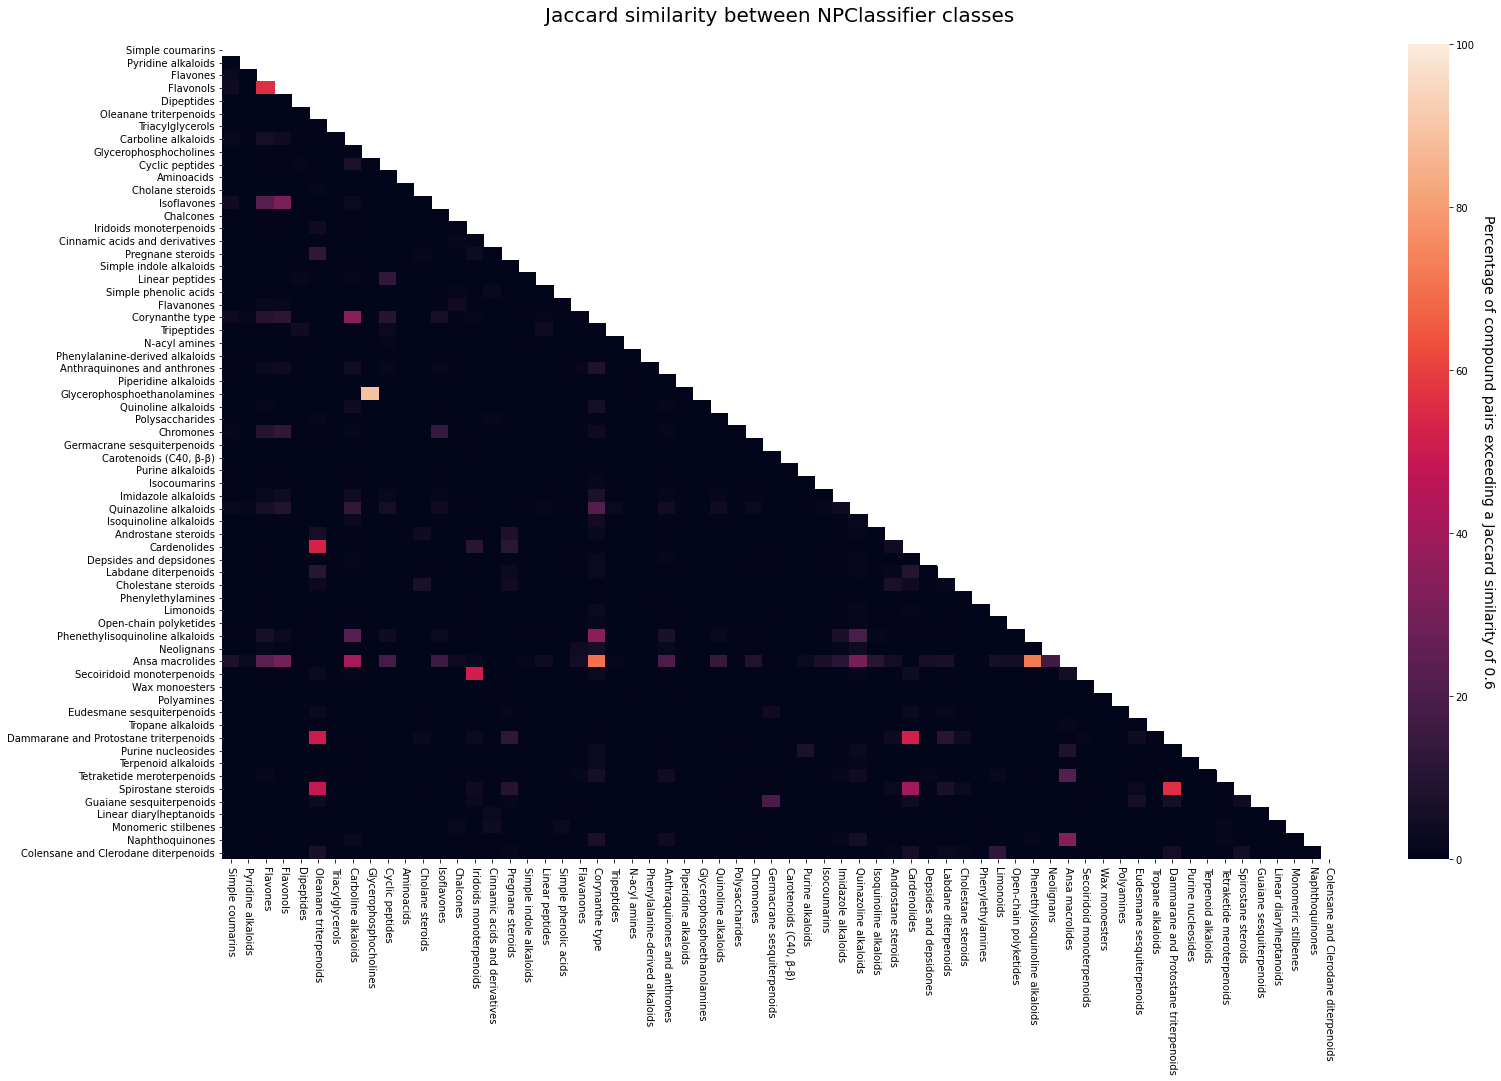

In [197]:
plt.figure(figsize=(25,15))
plt.title("Jaccard similarity between NPClassifier classes", fontsize = 20, y=1.02)
ax = sns.heatmap(npc_matrix, vmax = 100, cbar_kws={'label': 'Percentage of compound pairs exceeding a Jaccard similarity of 0.6'})
plt.xticks(rotation=270)
cbar = ax.collections[0].colorbar
cbar.set_label('Percentage of compound pairs exceeding a Jaccard similarity of 0.6', rotation = 270, labelpad = 20, fontsize = 14)
plt.savefig()

In [198]:
# Which class combinations have high similarity?
matrix = npc_matrix
[(matrix.index[x], matrix.columns[y]) for x, y in zip(*np.where(matrix.values >= 50))]

[('Flavonols', 'Flavones'),
 ('Glycerophosphoethanolamines', 'Glycerophosphocholines'),
 ('Cardenolides', 'Oleanane triterpenoids'),
 ('Ansa macrolides', 'Corynanthe type'),
 ('Ansa macrolides', 'Phenethylisoquinoline alkaloids'),
 ('Secoiridoid monoterpenoids', 'Iridoids monoterpenoids'),
 ('Dammarane and Protostane triterpenoids', 'Oleanane triterpenoids'),
 ('Dammarane and Protostane triterpenoids', 'Cardenolides'),
 ('Spirostane steroids', 'Dammarane and Protostane triterpenoids')]

# Similarity between Classyfire classes

In [ ]:
cf_matrix = jaccard_intergroup_similarity(metadata_df = spectrum_metadata.iloc[unique_inchi], var = "cf_classes", spectra = inchi_spectra, min_class_size=50, allow_multiclass_groups = False)

In [201]:
cf_matrix = pd.read_csv(data_dir+"Jaccard similarity between Classyfire classes.csv", sep = "\t", index_col = 0)

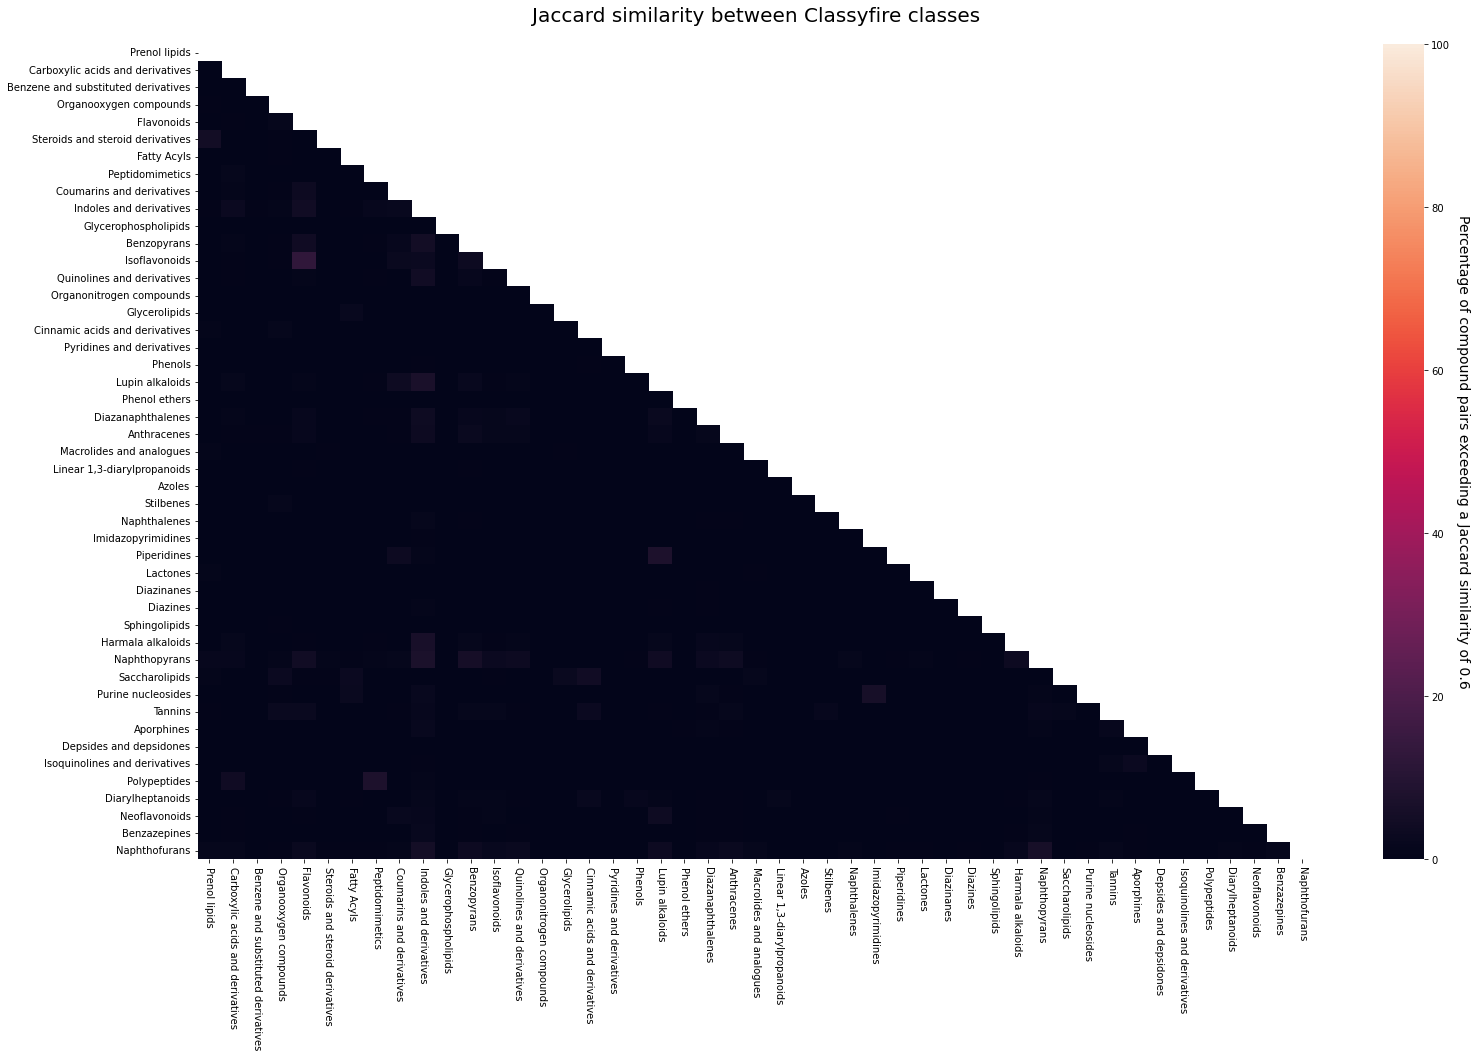

In [202]:
plt.figure(figsize=(25,15))
plt.title("Jaccard similarity between Classyfire classes", fontsize = 20, y=1.02)
ax = sns.heatmap(cf_matrix, vmax = 100, cbar_kws={'label': 'Percentage of compound pairs exceeding a Jaccard similarity of 0.6'})
plt.xticks(rotation=270)
cbar = ax.collections[0].colorbar
cbar.set_label('Percentage of compound pairs exceeding a Jaccard similarity of 0.6', rotation = 270, labelpad = 20, fontsize = 14)

In [216]:
# Which class combinations have high similarity?
matrix = cf_matrix
[(matrix.index[x], matrix.columns[y]) for x, y in zip(*np.where(matrix.values >= 50))]

[]